In [1]:
# Importing Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

In [2]:
team = pd.read_excel('team_data_model.xlsx')

In [3]:
# Storing Team Name in different dataframe to map it to the prediction later. 
team_name=team['Team_name']

# dropping some columns which doesn't look required for analysis
cols_to_drop=['venue','Team_name','Team_short_name','Year','Month','start_time','Team_id','Team_Tackles_total',
              'Team_Tackle_Points_capture','winning_score','loosing_score','Team_Tackle_Points_capture_bonus',
             'Team_Tackles_unsuccessful']
team=team.drop(cols_to_drop, axis=1)

# Converting season column to category 
team['Season']=team['Season'].astype('category')

team.shape

(1272, 20)

### Model

In [4]:
# Creating train and test. We will test the model on Season 7 data

train=team[team['Season']!='Season 7']

test=team[team['Season']=='Season 7']

# Dropping Season column as it is no more required. The test and train data has been split basis the season
y_train=train['Team_Tackles_successful']
train=train.drop(['Season','Team_Tackles_successful'], axis=1)


y_test=test['Team_Tackles_successful']
test=test.drop(['Season','Team_Tackles_successful'], axis=1)

print("Train Data Shape is: ", train.shape)
print("Test Data Shape is: ", test.shape)

Train Data Shape is:  (1040, 18)
Test Data Shape is:  (232, 18)


In [5]:
print('Train Shape is', train.shape)
print('y_train Shape is', y_train.shape)

Train Shape is (1040, 18)
y_train Shape is (1040,)


In [6]:
print('Test Shape is', test.shape)
print('y_test Shape is', y_test.shape)

Test Shape is (232, 18)
y_test Shape is (232,)


In [7]:
# Scaling the features
# storing the columns in a variable for avoiding them from lossing after scaling
X_train_cols=train.columns

scaler=StandardScaler()
train[X_train_cols]=scaler.fit_transform(train[X_train_cols])

train.head()

,home_team_name,Team_Points_total,Team_Points_all_out,Team_Points_extras,Team_Points_declare,Team_Raid_Points_total,Team_Raid_Points_touch,Team_Raid_Points_raid_bonus,Team_Tackle_Points_total,Team_Raids_total,Team_Raids_successful,Team_Raids_unsuccessful,Team_Raids_Empty,winning_team,toss_winner,toss_choice,toss_direction,winning_margin
0,-0.503003,-0.455681,-0.177082,-1.148447,0.0,1.244141,1.589658,-0.329941,-2.536457,-0.587692,1.247651,0.167896,-1.793128,-0.899275,-1.0,0.0,0.0,-1.336730
1,1.988060,1.633172,0.857554,-1.148447,0.0,1.778298,1.792063,0.431742,0.746760,-0.587692,1.473785,-1.716403,-0.760312,1.112007,1.0,0.0,0.0,1.336730
2,-0.503003,1.372066,1.892190,-1.148447,0.0,0.888036,1.589658,-1.091624,1.045234,-0.587692,0.795383,0.481946,-1.793128,1.112007,-1.0,0.0,0.0,1.814134
3,-0.503003,-0.455681,-1.211718,-1.148447,0.0,-0.536383,-1.244013,1.193426,1.045234,-0.365760,-0.109153,2.366244,-1.793128,-0.899275,1.0,0.0,0.0,-1.814134
4,-0.503003,0.980405,0.857554,-0.447105,0.0,0.353879,0.172823,0.431742,1.343708,-0.365760,-0.109153,0.795995,-0.760312,1.112007,1.0,0.0,0.0,0.286442


In [8]:
# Scaling the test data
test[X_train_cols]=scaler.transform(test[X_train_cols])
test.head()

,home_team_name,Team_Points_total,Team_Points_all_out,Team_Points_extras,Team_Points_declare,Team_Raid_Points_total,Team_Raid_Points_touch,Team_Raid_Points_raid_bonus,Team_Tackle_Points_total,Team_Raids_total,Team_Raids_successful,Team_Raids_unsuccessful,Team_Raids_Empty,winning_team,toss_winner,toss_choice,toss_direction,winning_margin
1028,-0.503003,0.849852,0.857554,0.254236,0.0,0.709984,0.577633,0.431742,0.149811,0.300034,0.343115,-0.146154,0.065941,1.112007,-1.0,0.0,0.0,0.668365
1029,-0.503003,-0.064021,-0.177082,0.254236,0.0,-0.180278,-0.231987,0.050901,0.149811,0.300034,0.116981,0.795995,-0.347185,-0.899275,1.0,0.0,0.0,-0.668365
1030,-0.503003,0.849852,0.857554,-0.447105,0.0,1.422193,1.589658,0.050901,-0.745612,0.300034,1.926053,-0.146154,-1.380002,1.112007,1.0,0.0,0.0,0.477404
1031,-0.503003,0.197085,-0.177082,0.955578,0.0,0.353879,0.577633,-0.329941,-0.447137,0.300034,1.021517,-0.774253,-0.140622,-0.899275,-1.0,0.0,0.0,-0.477404
1044,1.988060,-0.847341,-1.211718,-1.148447,0.0,-0.536383,-1.446418,1.574267,0.149811,-0.587692,-0.109153,0.481946,-0.760312,-0.899275,-1.0,0.0,0.0,-0.572884


In [9]:
# Defining alphas for identiying the optimum alphas for Lasso regression
params = {'alpha': [0.00000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,
                    0.6,0.7,0.8,0.9]}

# Lasso Modelling
lasso = Lasso()

# cross validation
folds=5
lasso_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_cv.fit(train, y_train) 

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    0.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-11, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                   0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4,
                                   0.5, 0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [10]:
# Printing the model output

lasso_cv_results = pd.DataFrame(lasso_cv.cv_results_)
lasso_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.012495,0.018219,0.003125,0.006249,1e-11,{'alpha': 1e-11},-0.730851,-0.735802,-0.641382,-0.764777,...,-0.718853,0.041349,6,-0.698995,-0.689342,-0.719829,-0.694588,-0.708373,-0.702225,0.010793
1,0.009371,0.007652,0.000000,0.000000,1e-08,{'alpha': 1e-08},-0.730851,-0.735802,-0.641382,-0.764777,...,-0.718853,0.041349,7,-0.698995,-0.689342,-0.719829,-0.694588,-0.708373,-0.702225,0.010793
2,0.003797,0.007594,0.003125,0.006249,1e-07,{'alpha': 1e-07},-0.730851,-0.735802,-0.641382,-0.764777,...,-0.718853,0.041349,8,-0.698994,-0.689342,-0.719829,-0.694588,-0.708373,-0.702225,0.010793
3,0.004438,0.002341,0.000200,0.000399,1e-06,{'alpha': 1e-06},-0.730849,-0.735803,-0.641382,-0.764776,...,-0.718853,0.041349,9,-0.698994,-0.689342,-0.719830,-0.694589,-0.708373,-0.702226,0.010793
4,0.004922,0.002475,0.000599,0.000489,1e-05,{'alpha': 1e-05},-0.730833,-0.735809,-0.641379,-0.764764,...,-0.718852,0.041347,5,-0.698992,-0.689345,-0.719838,-0.694595,-0.708375,-0.702229,0.010794


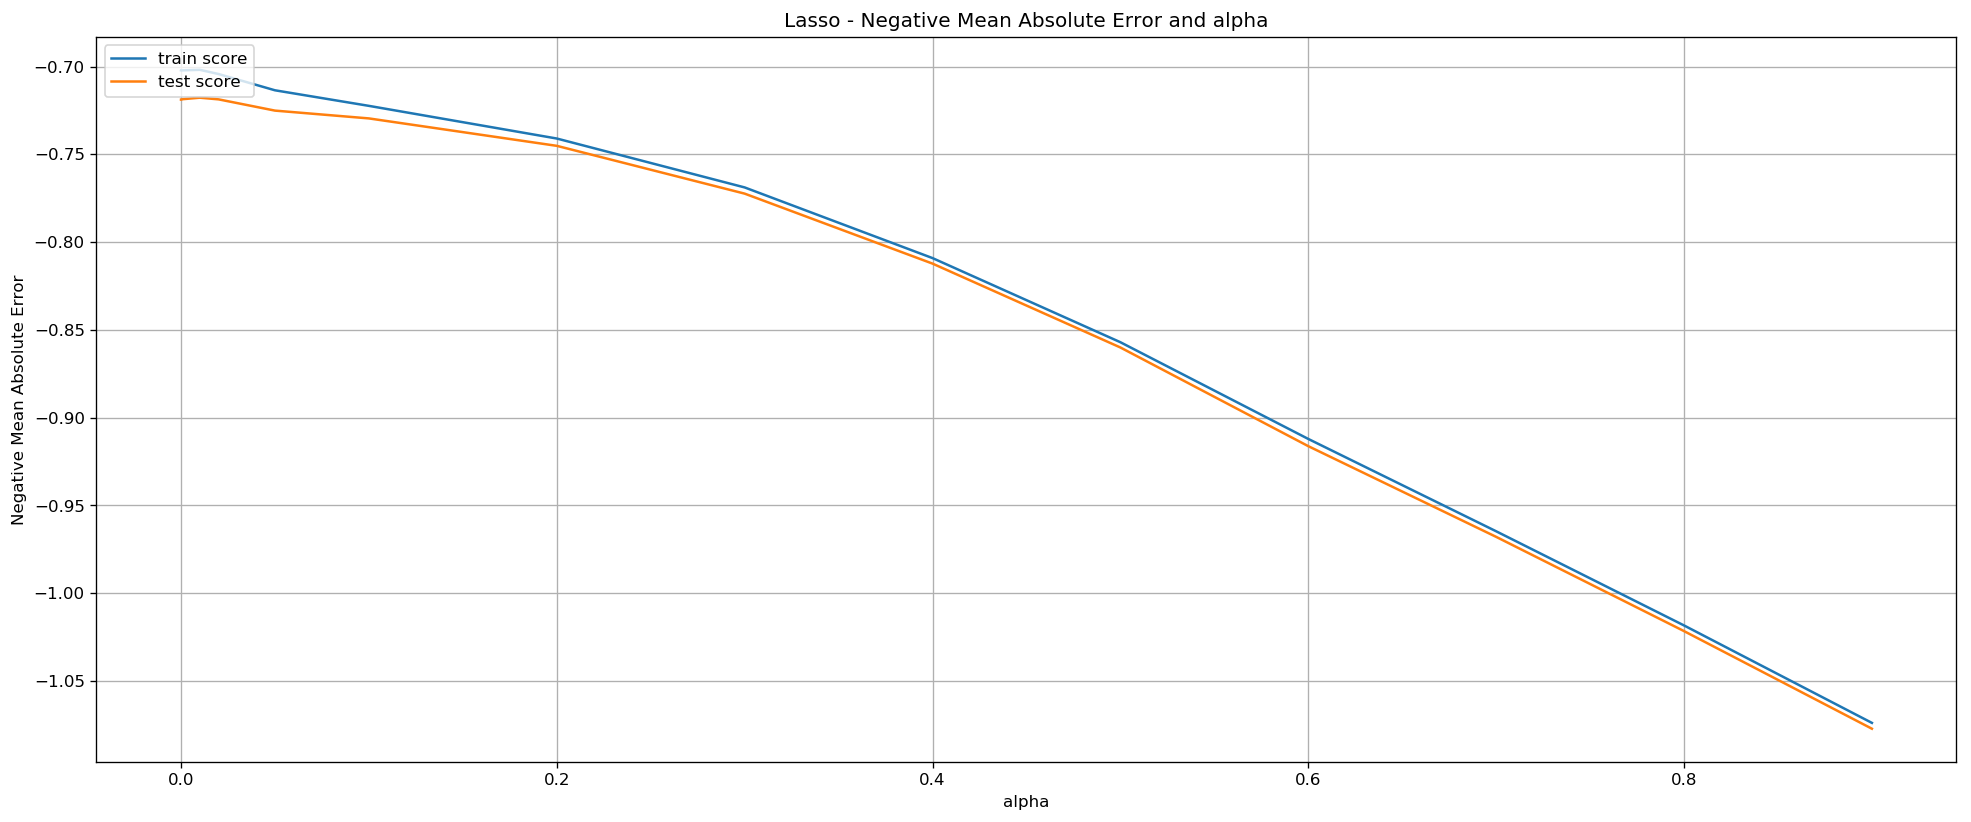

In [11]:
# plotting mean test and train scoes with alpha 
lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float32')

# plotting
plt.figure(num=None, figsize=(20, 8), dpi=120, facecolor='w', edgecolor='k')
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Lasso - Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.grid()
plt.show()

In [12]:
print(lasso_cv.best_params_['alpha'])

0.01


In [13]:
alpha = lasso_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)
lasso.fit(train, y_train) 

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [14]:
lasso.score(train, y_train)

0.9174302368487205

In [15]:
lasso.score(test, y_test)

0.904679191592864

In [16]:
y_test_pred=lasso.predict(test)
print(r2_score(y_test,y_test_pred))
print(np.sqrt(mean_squared_error(y_test,y_test_pred)))

0.904679191592864
0.9586744264402947


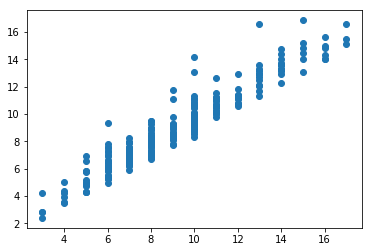

In [17]:
plt.scatter(y_test,y_test_pred)

In [18]:
features = np.abs(pd.Series(dict(zip(train.columns,lasso.coef_)))).sort_values(ascending=False)
print(features)

Team_Tackle_Points_total       2.535853
Team_Points_all_out            0.406670
Team_Raid_Points_total         0.287437
winning_margin                 0.209169
Team_Raids_successful          0.150652
Team_Points_extras             0.090293
winning_team                   0.089562
Team_Raids_total               0.089376
Team_Raids_unsuccessful        0.056712
toss_winner                    0.037622
home_team_name                 0.034751
Team_Raid_Points_raid_bonus    0.033323
Team_Raids_Empty               0.000000
toss_direction                 0.000000
Team_Raid_Points_touch         0.000000
Team_Points_declare            0.000000
toss_choice                    0.000000
Team_Points_total              0.000000
dtype: float64


In [19]:
defender_team = pd.DataFrame(np.array([team_name.loc[test.index].values,y_test_pred]).T,columns=['Team','Tackle Capture Points'])
defender_team['Tackle Capture Points'] = defender_team['Tackle Capture Points'].astype('int')
defender_team = defender_team[['Team','Tackle Capture Points']].groupby('Team').sum().sort_values(by='Tackle Capture Points',ascending=False)
defender_team.head()

,Tackle Capture Points
Team,
Puneri Paltan,193
Gujarat Fortunegiants,189
Jaipur Pink Panthers,183
U.P. Yoddha,172
Bengaluru Bulls,170
